In [1]:
# getting the dataset from kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dineshgudimetla","key":"80a4d7012fb20118fa6cea1d69191635"}'}

In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d gpiosenka/railway-track-fault-detection-resized-224-x-224

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/railway-track-fault-detection-resized-224-x-224
License(s): CC-BY-SA-4.0


In [5]:
import zipfile

with zipfile.ZipFile("/content/railway-track-fault-detection-resized-224-x-224.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")
print("Extracted successfully")

Extracted successfully


In [6]:
import os
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [7]:
# Pretrained EfficientNetB0 (no classification head, avg pooling)
feature_extractor = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    pooling='avg',  # Outputs a 1280-length feature vector
    input_shape=(224, 224, 3)
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


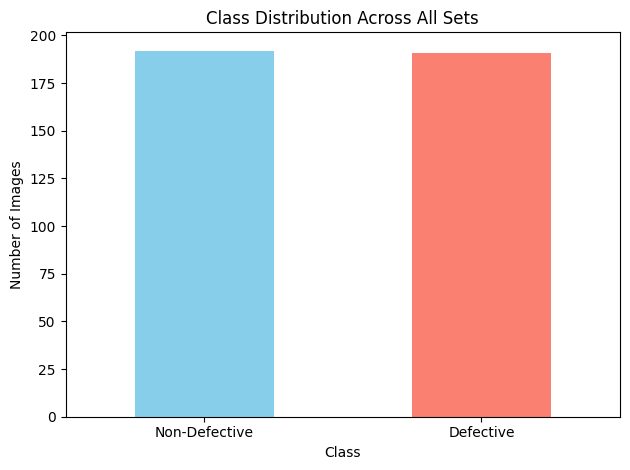

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine labels for train/val/test
all_labels = y_train.tolist() + y_val.tolist() + y_test.tolist()
label_names = ['Non-Defective' if label == 0 else 'Defective' for label in all_labels]

# Create dataframe and plot
df = pd.DataFrame({'Label': label_names})
df['Label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution Across All Sets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


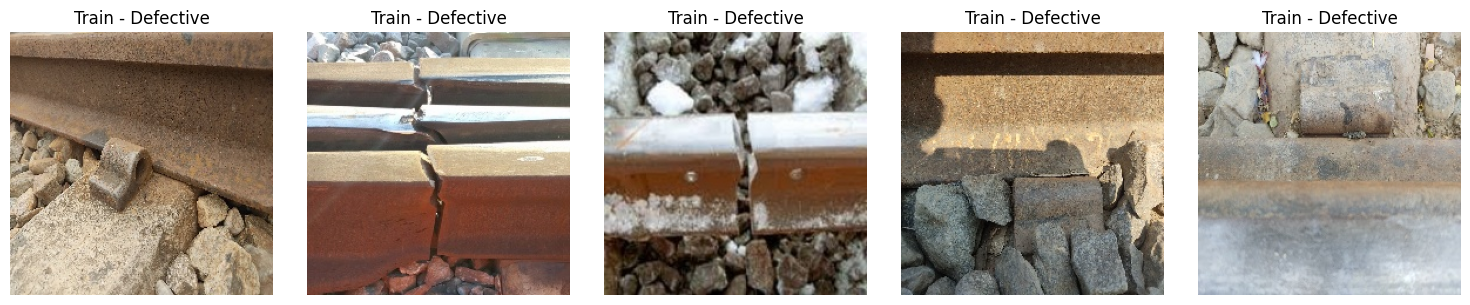

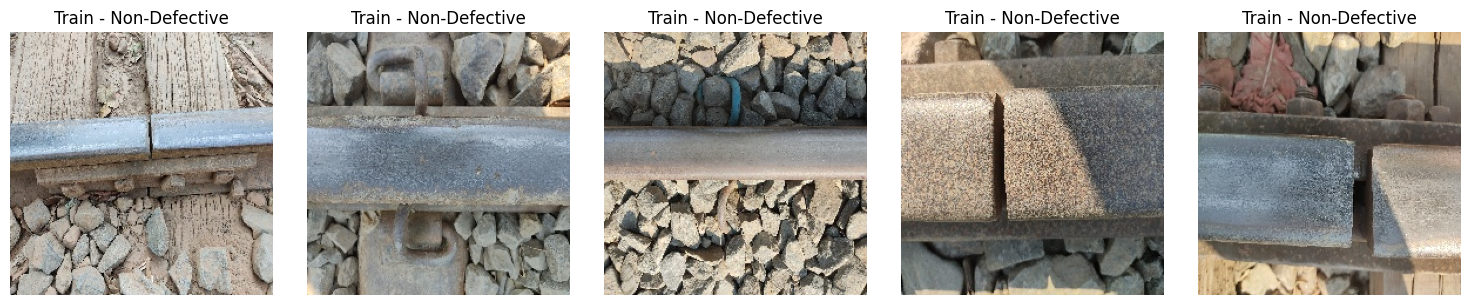

In [46]:
import random
import matplotlib.pyplot as plt

def show_sample_images(folder_path, title, num_images=5):
    img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected = random.sample(img_files, min(num_images, len(img_files)))
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(selected):
        img = load_img(os.path.join(folder_path, fname), target_size=(224, 224))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{title}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images("/content/dataset/train/Defective", "Train - Defective")
show_sample_images("/content/dataset/train/Non defective", "Train - Non-Defective")


In [8]:
def extract_features_from_folder(folder_path, label):
    features = []
    labels = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, fname)
            img = load_img(img_path, target_size=(224, 224))  # Resize
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)  # EfficientNet expects [0, 1]
            img_array = np.expand_dims(img_array, axis=0)  # Batch dimension
            feature = feature_extractor.predict(img_array, verbose=0)[0]
            features.append(feature)
            labels.append(label)
    return features, labels


In [9]:
# Train
X_train_def, y_train_def = extract_features_from_folder('/content/dataset/train/Defective', 1)
X_train_non, y_train_non = extract_features_from_folder('/content/dataset/train/Non defective', 0)

# Validation
X_val_def, y_val_def = extract_features_from_folder('/content/dataset/valid/Defective', 1)
X_val_non, y_val_non = extract_features_from_folder('/content/dataset/valid/Non defective', 0)

# Test
X_test_def, y_test_def = extract_features_from_folder('/content/dataset/test/Defective', 1)
X_test_non, y_test_non = extract_features_from_folder('/content/dataset/test/Non defective', 0)

# Combine datasets
X_train = np.array(X_train_def + X_train_non)
y_train = np.array(y_train_def + y_train_non)

X_val = np.array(X_val_def + X_val_non)
y_val = np.array(y_val_def + y_val_non)

X_test = np.array(X_test_def + X_test_non)
y_test = np.array(y_test_def + y_test_non)


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


params = {'n_estimators': [50, 100, 150, 200, 250]}
grid = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5)
grid.fit(X_train, y_train)

print("Best n_estimators:", grid.best_params_['n_estimators'])

Best n_estimators: 200


In [12]:
clf = grid.best_estimator_

📊 Validation Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

Non-Defective       0.85      0.90      0.88        31
    Defective       0.90      0.84      0.87        31

     accuracy                           0.87        62
    macro avg       0.87      0.87      0.87        62
 weighted avg       0.87      0.87      0.87        62



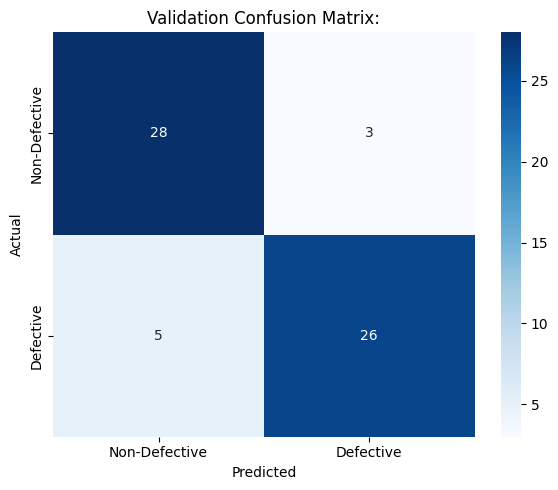

In [52]:
val_probs = clf.predict_proba(X_val)

# Set your desired threshold here
threshold = 0.5
y_val_pred = [1 if prob[1] >= threshold else 0 for prob in val_probs]

# Classification Report
print(f"📊 Validation Classification Report (Threshold = {threshold}):")
print(classification_report(y_val, y_val_pred, target_names=['Non-Defective', 'Defective']))

# Confusion Matrix
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Defective', 'Defective'], yticklabels=['Non-Defective', 'Defective'])
plt.title(f"Validation Confusion Matrix:")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


📊 Test Classification Report:
               precision    recall  f1-score   support

Non-Defective       0.82      0.82      0.82        11
    Defective       0.82      0.82      0.82        11

     accuracy                           0.82        22
    macro avg       0.82      0.82      0.82        22
 weighted avg       0.82      0.82      0.82        22



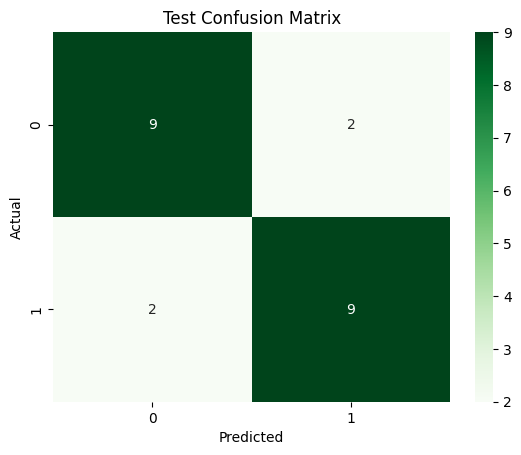

In [64]:
test_probs = clf.predict_proba(X_test)
y_test_pred = [1 if prob[1] > 0.45 else 0 for prob in test_probs]

print("📊 Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Non-Defective', 'Defective']))

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
feature_extractor.save("mobilenet_feature_extractor.keras")

In [23]:
import joblib
joblib.dump(clf, "random_forest_model.pkl")

['random_forest_model.pkl']

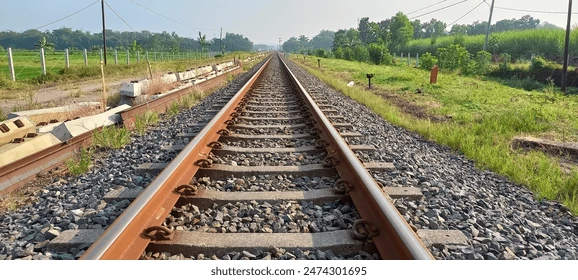

Classification Result: Non-Defective


In [79]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import joblib
from google.colab.patches import cv2_imshow


clf = joblib.load("/content/random_forest_defect_classifier.pkl")
feature_extractor = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

def classify_image(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    display_img = cv2.imread(img_path)
    cv2_imshow(display_img)

    features = feature_extractor.predict(img_array, verbose=0)[0].reshape(1, -1)
    probs = clf.predict_proba(features)[0]

    predicted_label = 1 if probs[1] >= 0.7 else 0
    label_text = "Defective" if predicted_label == 1 else "Non-Defective"

    return label_text

result = classify_image("/content/railway-track-railroad-structure-on-260nw-2474301695.webp")
print("Classification Result:", result)
